In [1]:
import xarray as xr # Import the Xarray package
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Import the Numpy package
import cartopy,cartopy.crs as ccrs # Plot maps
import cartopy.feature as cfeature # Collection of points, lines and polygons
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER # Add gridlines and tick labels to a map
import cartopy.io.shapereader as shpreader # Oriented shapefile reader
from netCDF4 import Dataset # Read/Write NetCDF4 files
from datetime import datetime, timedelta # Basics Dates and time types
from matplotlib import cm # Colormap handling utilities
import metpy
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from utilities import loadCPT
from scipy.ndimage.filters import maximum_filter, minimum_filter
import scipy.ndimage as ndimage
from ecmwf.opendata import Client

In [2]:
ds13=xr.open_dataset('C:/Users/igorr/Downloads/OR_ABI-L2-TPWF-M6_G16_s20233071230207_e20233071239515_c20233071241144.nc')
ds13

<xarray.Dataset>
Dimensions:                                           (y: 1086, x: 1086, number_of_time_bounds: 2, number_of_image_bounds: 2, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_lat_bounds: 2, sounding_emissive_bands: 7)
Coordinates:
    t                                                 datetime64[ns] ...
  * y                                                 (y) float32 0.1519 ... ...
  * x                                                 (x) float32 -0.1519 ......
    y_image                                           float32 ...
    x_image                                           float32 ...
    retrieval_local_zenith_angle                      float32 ...
    quantitative_local_zenith_angle                   float32 ...
    solar_zenith_angle                                float32 ...
    latitude                                          float32 ...
    sounding_emissive_wavelengths                     (sounding_emissive_bands) float32 ...
    sounding_emissive_band_ids                        (sounding_emissive_bands) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds, number_of_LZA_bounds, number_of_SZA_bounds, number_of_lat_bounds, sounding_emissive_bands
Data variables: (12/29)
    TPW                                               (y, x) float32 ...
    DQF_Overall                                       (y, x) float32 ...
    DQF_Retrieval                                     (y, x) float32 ...
    DQF_SkinTemp                                      (y, x) float32 ...
    time_bounds                                       (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                            int32 ...
    ...                                                ...
    latitude_bounds                                   (number_of_lat_bounds) float32 ...
    percent_uncorrectable_L0_errors                   float32 ...
    percent_uncorrectable_GRB_errors                  float32 ...
    total_attempted_retrievals                        float64 ...
    mean_obs_modeled_diff_sounding_emissive_bands     (sounding_emissive_bands) float32 ...
    std_dev_obs_modeled_diff_sounding_emissive_bands  (sounding_emissive_bands) float32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2023-11-03T12:30:20.7Z
    time_coverage_end:         2023-11-03T12:39:51.5Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        7f1b1e54-ef1e-461e-a2f4-05459b3eee19

In [7]:
dat13 = ds13.metpy.parse_cf('TPW')
dat13=dat13
geos = dat13.metpy.cartopy_crs

x = dat13.x
y = dat13.y

In [8]:
# Scan's start time, converted to datetime object
scan_start = datetime.strptime(ds13.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
date=scan_start
# Scan's end time, converted to datetime object
scan_end = datetime.strptime(ds13.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(ds13.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
midpoint = str(ds13['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : {}'.format(scan_start))
print('Scan midpoint : {}'.format(scan_mid))
print('Scan End      : {}'.format(scan_end))
print('File Created  : {}'.format(file_created))
print('Scan Duration : {:.2f} minutes'.format((scan_end-scan_start).seconds/60))

Scan Start    : 2023-11-03 12:30:20.700000
Scan midpoint : 2023-11-03 12:35:06.100000
Scan End      : 2023-11-03 12:39:51.500000
File Created  : 2023-11-03 12:41:14.400000
Scan Duration : 9.50 minutes


In [5]:
cores=['#c7c7c7', '#b1b1b2','#9c9c9d','#878889','#737375','#5f6062','#4c4d50','#3a3b3e',
       '#573e21','#6b4f2d','#7f6139','#947446','#a98753','#bf9b61','#d4b06f',
       '#b8b9f9','#a4a4e4','#9090cf','#7d7cba','#6a69a6','#575692','#45447f',
       '#9d9d54','#aaaa4f','#b7b849','#c4c541','#d1d337','#dee129','#ecef0f',
       '#e46b55','#d15b48','#bf4c3c','#ad3c30','#9b2c24','#891b19','#77040e',
       '#4b0f4d','#651267','#801482','#9c149e','#b913bb','#d80ed9','#f702f7',
       '#2501f0','#0051ff','#0075ff','#0093ff','#00adff','#00c4ff','#00daff']
my_cmap = ListedColormap(cores, name="my_cmap")
levels=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,
        78,80,82,84,86,88,90,92,94,96,98,100]

In [19]:
# xx,yy=np.meshgrid(dat13.x,dat13.y)

Text(1.0, 1.0, '12:30UTC 03/Nov/2023')

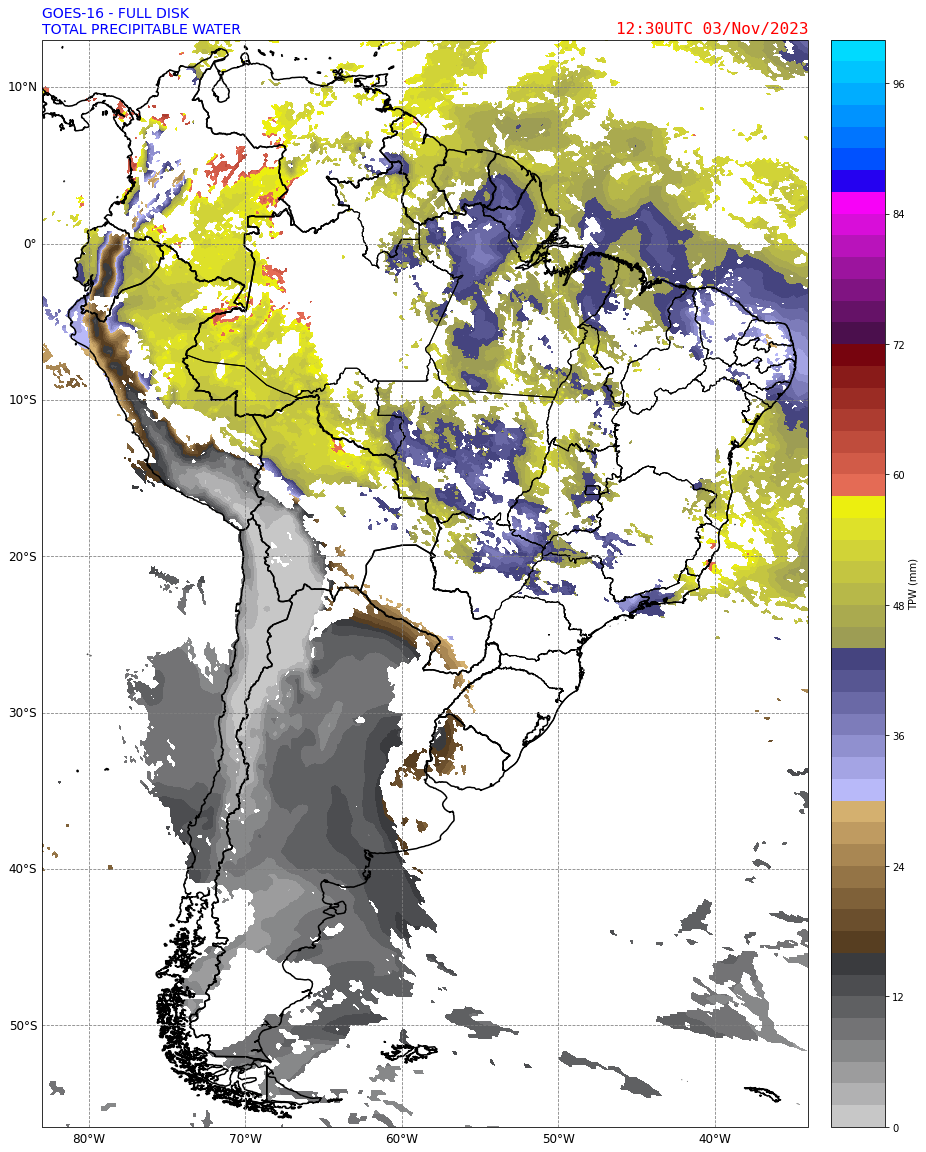

In [11]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution="10m",edgecolor='k',linestyle='-',linewidth=0.3)
ax.set_extent([-83,-34,12,-54]) #América do Sul
#ax.set_extent([-58,-47,-34,-22]) #Sul do Brasil
#ax.set_extent([-54.8,-47.9,-22.4,-26.8]) #Paraná
#ax.set_extent([-72,-47,-20,-35])

im=ax.contourf(x,y,dat13,levels=levels,
               cmap=my_cmap,origin='upper',
               extent=(x.min(), x.max(), y.min(), y.max()),
               transform=geos)

states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/10/ne_10m_admin_0_countries.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=1.5)
states = list(shpreader.Reader
              ('C:/Users/igorr/OneDrive/Área de Trabalho/MAPAS/BR/BR_UF_2022.shp').geometries())
ax.add_geometries(states, ccrs.PlateCarree(), edgecolor='k',facecolor='none',linestyle='-',linewidth=1.)

g1=ax.gridlines(crs=ccrs.PlateCarree(),linestyle='--',color='gray',draw_labels=True)
g1.right_labels=False
g1.top_labels=False
g1.yformatter=LATITUDE_FORMATTER
g1.xformatter=LONGITUDE_FORMATTER
g1.ylabel_style={'size':12,'color':'black'}
g1.xlabel_style={'size':12,'color':'black'}
#cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.06,orientation='horizontal')
cbar=plt.colorbar(im,ax=ax,pad=0.02,fraction=0.049,orientation='vertical')
cbar.set_label(label='TPW (mm)',size=10)

plt.title('GOES-16 - FULL DISK\nTOTAL PRECIPITABLE WATER',
          fontsize=14,loc='left',color='blue')

plt.title('{}'.format(scan_start.strftime('%H:%MUTC %d/%b/%Y')),fontsize=14,loc='right',
          color='red',fontweight='normal',fontfamily='monospace')
#plt.savefig('GOES16_TPW_AS_'+scan_start.strftime('%H_%MUTC_%d_%b_%Y')+'.jpeg',dpi=300,bbox_inches='tight')